# <center>Malaria Cell Images Dataset</center>

## Modules

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image

import os
from matplotlib.image import imread

In [19]:
train_path = 'cell_images\\train\\'
test_path = 'cell_images\\test\\'

In [20]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [21]:
os.listdir(train_path)

['parasitized', 'uninfected']

## Observing the images

In [25]:
para_cell = train_path+'parasitized\\' + os.listdir(train_path+'parasitized')[0]

In [27]:
imread(para_cell).shape

(148, 142, 3)

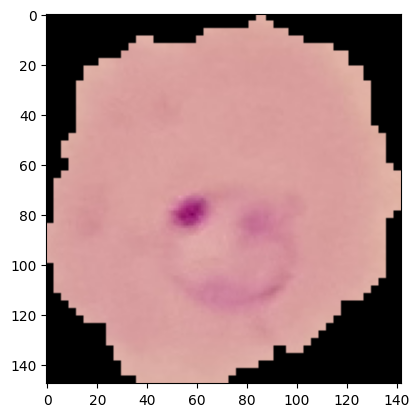

In [28]:
plt.imshow(imread(para_cell))

In [32]:
uninfected_cell = train_path+'uninfected\\' + os.listdir(train_path+'uninfected')[0]

In [33]:
imread(uninfected_cell).shape

(139, 160, 3)

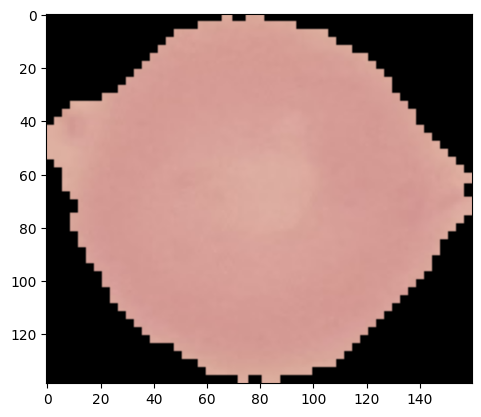

In [34]:
plt.imshow(imread(uninfected_cell))

In [36]:
len(os.listdir(train_path+'parasitized')), len(os.listdir(train_path+'uninfected'))

(12480, 12480)

In [37]:
len(os.listdir(test_path+'parasitized')), len(os.listdir(test_path+'uninfected'))

(1300, 1300)

## Generalize the dimension of each image

In [39]:
dim1 = []
dim2 = []

for image_filename in os.listdir(test_path+'uninfected'):
    
    img = imread(test_path+'uninfected\\'+image_filename)
    
    d1, d2, colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

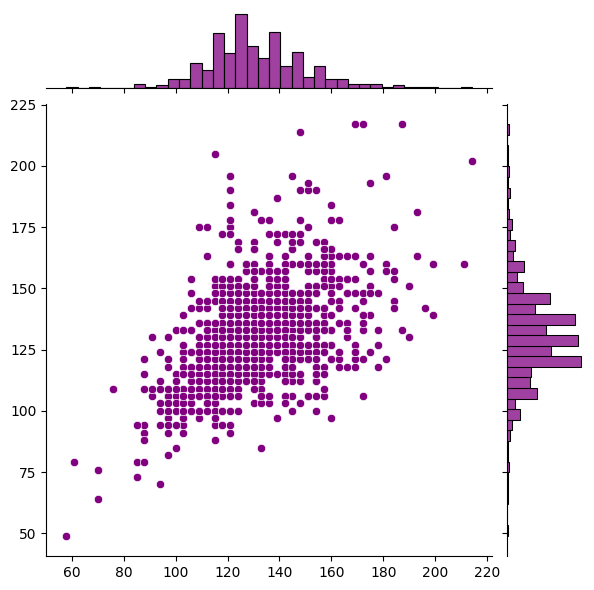

In [41]:
sns.jointplot(x=dim1, y=dim2, color='purple')
plt.show()

In [43]:
np.mean(dim1), np.mean(dim2)

(130.92538461538462, 130.75)

In [44]:
image_shape = (130, 130, 3)

In [45]:
# data_points
130*130*3

50700

In [51]:
imread(uninfected_cell).max(), imread(para_cell).max()

(0.88235295, 0.9098039)

In [52]:
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')
# standarize (0-1)            rescale=1/255)

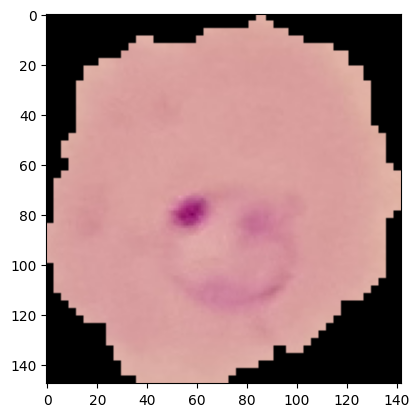

In [56]:
para_img = imread(para_cell)
plt.imshow(para_img)

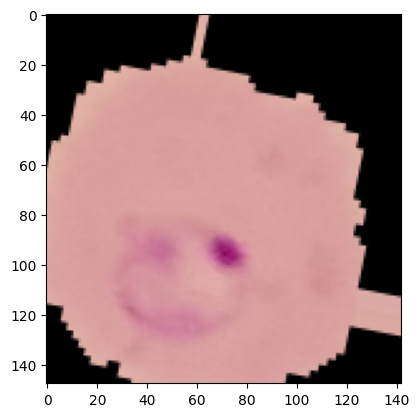

In [60]:
plt.imshow(image_gen.random_transform(para_img))

In [61]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [63]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Train Model

In [67]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [70]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [71]:
batch_size = 16

In [72]:
image_shape, image_shape[:2]

((130, 130, 3), (130, 130))

In [74]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], 
                                                color_mode='rgb', batch_size=batch_size,
                                               class_mode='binary', shuffle=True)

Found 24958 images belonging to 2 classes.


In [75]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], 
                                                color_mode='rgb', batch_size=batch_size,
                                               class_mode='binary', shuffle=False)

Found 2600 images belonging to 2 classes.


In [76]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
results = model.fit(train_image_gen, epochs=20, 
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

**Here, since the training is gonna take a lot of time,  
we are gonna load a pre-trained model**

In [79]:
from tensorflow.keras.models import load_model

In [81]:
model = load_model('malaria_detector.h5')

In [83]:
model.evaluate(test_image_gen)

163/163 [==============================] - 26s 159ms/step - loss: 35.4165 - accuracy: 0.8750


[35.41650390625, 0.875]

In [84]:
model.metrics_names

['loss', 'accuracy']

In [85]:
predictions = model.predict(test_image_gen)

163/163 [==============================] - 28s 170ms/step


In [86]:
predictions = predictions > 0.5

In [87]:
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [89]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [90]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.81      0.98      0.88      1300
           1       0.97      0.76      0.86      1300

    accuracy                           0.87      2600
   macro avg       0.89      0.87      0.87      2600
weighted avg       0.89      0.87      0.87      2600



In [91]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1272,   28],
       [ 306,  994]], dtype=int64)

In [96]:
my_image = image.load_img(para_cell, target_size=image_shape)

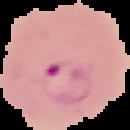

In [97]:
my_image

In [98]:
my_image_arr = image.img_to_array(my_image)

In [101]:
my_image_arr.shape
# (1, 130, 130, 3) # 1- batch size

(130, 130, 3)

In [103]:
my_image_arr = np.expand_dims(my_image_arr, axis=0)

In [104]:
my_image_arr.shape

(1, 130, 130, 3)

In [105]:
model.predict(my_image_arr)

1/1 [==============================] - 0s 129ms/step


array([[0.]], dtype=float32)

In [106]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

**Thus, the cell is infected**